# 🧬 Mutated Protein Modeling Pipeline for Binder Design

**Author:** Automated Pipeline for Structural Bioinformatics

## Objective
This notebook implements a complete pipeline for:
1. Fetching Wild Type (WT) structures from AlphaFold Database
2. Applying point mutations to the sequence
3. Generating conformations of the mutated protein using **BioEmu** (diffusion-based generative model)
4. Performing intelligent comparative structural analysis (Core vs Global RMSD)
5. Selecting the best candidate for input into **RFdiffusion** (binder design)

---

### Physics Behind the Analysis

**Why separate Core and IDRs (Intrinsically Disordered Regions)?**

- Proteins often have flexible regions (loops, N/C-terminal tails) that naturally exhibit high conformational variance
- AlphaFold's **pLDDT** (predicted Local Distance Difference Test) is an excellent proxy for structural order:
  - pLDDT > 70-80: Well-structured regions (α-helices, β-sheets)
  - pLDDT < 70: Potentially disordered or flexible regions
- For binder design, we want to preserve the **central structural fold**, not flexible tails
- Core-based alignment prevents natural IDR fluctuations from dominating the RMSD

---
## 1. 🔧 Setup and Installation

In [38]:
# GPU Check - REQUIRED for BioEmu
import subprocess
import sys

def check_gpu_availability() -> bool:
    """Check if GPU is available (required for BioEmu)."""
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ GPU detected!")
            print(result.stdout)
            return True
        else:
            print("❌ No GPU detected.")
            return False
    except FileNotFoundError:
        print("❌ nvidia-smi not found. Make sure you're in a GPU-enabled environment.")
        return False

# Check GPU
gpu_available = check_gpu_availability()

if not gpu_available:
    print("\n⚠️  WARNING: BioEmu requires GPU for efficient execution.")
    print("   In Google Colab: Runtime > Change runtime type > GPU")

✅ GPU detected!
Thu Feb  5 17:26:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------------

In [39]:
# Install dependencies
!pip install -q biopython requests py3dmol matplotlib seaborn

# Install BioEmu (generative model for conformational sampling)
# Documentation: https://github.com/microsoft/bioemu
!pip install -q bioemu

# Verify BioEmu installation and show available API
print("\n🔍 Checking BioEmu installation...")
try:
    import bioemu
    available_attrs = [attr for attr in dir(bioemu) if not attr.startswith('_')]
    print(f"✅ BioEmu version: {getattr(bioemu, '__version__', 'unknown')}")
    print(f"   Available API: {available_attrs}")
except ImportError as e:
    print(f"❌ BioEmu import failed: {e}")
    print("   Trying alternative installation...")
    !pip install -q git+https://github.com/microsoft/bioemu.git

print("\n✅ All dependencies installed!")


🔍 Checking BioEmu installation...
✅ BioEmu version: 1.2.0
   Available API: []

✅ All dependencies installed!


In [40]:
# Main imports
import os
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass, field

import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.PDB import PDBParser, PDBIO, Select, Superimposer
from Bio.PDB.Structure import Structure
from Bio.PDB.Model import Model
from Bio.PDB.Chain import Chain
from Bio.PDB.Residue import Residue
from Bio.Seq import Seq

import py3Dmol

# Visualization settings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Imports loaded successfully!")

✅ Imports loaded successfully!


In [41]:
# Directory configuration
BASE_DIR = Path("./mutation_pipeline_results")
STRUCTURES_DIR = BASE_DIR / "structures"
BIOEMU_DIR = BASE_DIR / "bioemu_results"
OUTPUT_DIR = BASE_DIR / "output"

# Create directories
for directory in [BASE_DIR, STRUCTURES_DIR, BIOEMU_DIR, OUTPUT_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"📁 Directories created at: {BASE_DIR.absolute()}")

📁 Directories created at: /content/mutation_pipeline_results


---
## 2. 📥 `ProteinDataHandler` Class

Responsible for:
- Fetching FASTA sequences from UniProt
- Downloading predicted structures from AlphaFold Database
- Applying and validating point mutations

In [42]:
# Amino acid code mapping (1-letter <-> 3-letter)
AA_CODE_MAP: Dict[str, str] = {
    'A': 'ALA', 'C': 'CYS', 'D': 'ASP', 'E': 'GLU', 'F': 'PHE',
    'G': 'GLY', 'H': 'HIS', 'I': 'ILE', 'K': 'LYS', 'L': 'LEU',
    'M': 'MET', 'N': 'ASN', 'P': 'PRO', 'Q': 'GLN', 'R': 'ARG',
    'S': 'SER', 'T': 'THR', 'V': 'VAL', 'W': 'TRP', 'Y': 'TYR'
}

AA_3TO1: Dict[str, str] = {v: k for k, v in AA_CODE_MAP.items()}


@dataclass
class MutationInfo:
    """Data structure for mutation information."""
    original_aa: str  # Original amino acid (1-letter)
    position: int     # Position in sequence (1-indexed)
    mutant_aa: str    # Mutant amino acid (1-letter)

    @property
    def notation(self) -> str:
        """Returns standard mutation notation (e.g., D40G)."""
        return f"{self.original_aa}{self.position}{self.mutant_aa}"

    @classmethod
    def from_string(cls, mutation_str: str) -> 'MutationInfo':
        """Parses mutation string (e.g., 'D40G')."""
        mutation_str = mutation_str.strip().upper()

        if len(mutation_str) < 3:
            raise ValueError(f"Invalid mutation format: '{mutation_str}'. Use format like 'D40G'.")

        original_aa = mutation_str[0]
        mutant_aa = mutation_str[-1]

        try:
            position = int(mutation_str[1:-1])
        except ValueError:
            raise ValueError(f"Invalid position in mutation: '{mutation_str}'.")

        if original_aa not in AA_CODE_MAP:
            raise ValueError(f"Invalid original amino acid: '{original_aa}'.")
        if mutant_aa not in AA_CODE_MAP:
            raise ValueError(f"Invalid mutant amino acid: '{mutant_aa}'.")
        if position < 1:
            raise ValueError(f"Position must be >= 1, received: {position}.")

        return cls(original_aa=original_aa, position=position, mutant_aa=mutant_aa)

In [43]:
class ProteinDataHandler:
    """
    Handler for protein data retrieval and manipulation.

    Responsibilities:
    - Fetch FASTA sequences from UniProt
    - Download AlphaFold structures
    - Apply and validate mutations
    """

    UNIPROT_FASTA_URL = "https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    ALPHAFOLD_PDB_URL = "https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v6.pdb"

    def __init__(self, output_dir: Path = STRUCTURES_DIR):
        """Initialize the handler.

        Args:
            output_dir: Directory to save downloaded structures.
        """
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self._sequence_cache: Dict[str, str] = {}

    def fetch_sequence(self, uniprot_id: str) -> str:
        """
        Fetch official FASTA sequence from UniProt.

        Args:
            uniprot_id: UniProt identifier (e.g., 'P12345').

        Returns:
            Amino acid sequence as string.

        Raises:
            ValueError: If ID not found or request error.
        """
        uniprot_id = uniprot_id.strip().upper()

        # Check cache
        if uniprot_id in self._sequence_cache:
            print(f"📋 Sequence {uniprot_id} retrieved from cache.")
            return self._sequence_cache[uniprot_id]

        url = self.UNIPROT_FASTA_URL.format(uniprot_id=uniprot_id)

        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            if response.status_code == 404:
                raise ValueError(f"UniProt ID '{uniprot_id}' not found.") from e
            raise ValueError(f"Error fetching sequence: {e}") from e
        except requests.exceptions.RequestException as e:
            raise ValueError(f"Connection error to UniProt: {e}") from e

        # Parse FASTA
        lines = response.text.strip().split('\n')
        sequence = ''.join(line.strip() for line in lines if not line.startswith('>'))

        if not sequence:
            raise ValueError(f"Empty sequence returned for {uniprot_id}.")

        # Validate sequence
        invalid_chars = set(sequence) - set(AA_CODE_MAP.keys())
        if invalid_chars:
            print(f"⚠️  Non-standard characters found and will be ignored: {invalid_chars}")
            sequence = ''.join(aa for aa in sequence if aa in AA_CODE_MAP)

        self._sequence_cache[uniprot_id] = sequence
        print(f"✅ Sequence {uniprot_id} downloaded: {len(sequence)} amino acids.")

        return sequence

    def fetch_alphafold_structure(self, uniprot_id: str) -> Path:
        """
        Download predicted structure from AlphaFold Database (v6).

        Args:
            uniprot_id: UniProt identifier.

        Returns:
            Path to downloaded PDB file.

        Raises:
            ValueError: If structure not available.
        """
        uniprot_id = uniprot_id.strip().upper()
        output_path = self.output_dir / f"AF-{uniprot_id}-F1-model_v6.pdb"

        # Check if already exists
        if output_path.exists():
            print(f"📂 AlphaFold structure already exists: {output_path}")
            return output_path

        url = self.ALPHAFOLD_PDB_URL.format(uniprot_id=uniprot_id)

        try:
            response = requests.get(url, timeout=60)
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            if response.status_code == 404:
                raise ValueError(
                    f"AlphaFold structure not available for '{uniprot_id}'. "
                    f"Please verify the UniProt ID is correct."
                ) from e
            raise ValueError(f"Error downloading structure: {e}") from e
        except requests.exceptions.RequestException as e:
            raise ValueError(f"Connection error to AlphaFold DB: {e}") from e

        # Save file
        with open(output_path, 'w') as f:
            f.write(response.text)

        print(f"✅ AlphaFold structure downloaded: {output_path}")
        return output_path

    def apply_mutation(
        self,
        sequence: str,
        mutation_str: str
    ) -> Tuple[str, MutationInfo]:
        """
        Apply a point mutation to the sequence.

        Args:
            sequence: Original amino acid sequence.
            mutation_str: Mutation string in format 'D40G'
                          (Asp at position 40 -> Gly).

        Returns:
            Tuple containing:
            - Mutated sequence
            - MutationInfo object with mutation details

        Raises:
            ValueError: If mutation is invalid or inconsistent.
        """
        mutation = MutationInfo.from_string(mutation_str)

        # Validate position
        if mutation.position > len(sequence):
            raise ValueError(
                f"Position {mutation.position} exceeds sequence length ({len(sequence)} aa)."
            )

        # Validate original amino acid (position 1-indexed -> 0-indexed)
        idx = mutation.position - 1
        actual_aa = sequence[idx]

        if actual_aa != mutation.original_aa:
            raise ValueError(
                f"Mutation inconsistency {mutation.notation}: "
                f"expected '{mutation.original_aa}' at position {mutation.position}, "
                f"but found '{actual_aa}'."
            )

        # Apply mutation
        mutated_sequence = sequence[:idx] + mutation.mutant_aa + sequence[idx + 1:]

        print(f"✅ Mutation {mutation.notation} applied successfully.")
        print(f"   Context: ...{sequence[max(0, idx-5):idx]}[{actual_aa}→{mutation.mutant_aa}]{sequence[idx+1:idx+6]}...")

        return mutated_sequence, mutation

---
## 3. 🔬 Conformation Generation (`BioEmuRunner`)

**BioEmu** is a diffusion-based generative model for sampling the conformational ensemble of proteins.

The model learns the Boltzmann distribution of protein conformations, enabling:
- Exploration of the conformational landscape
- 3D structure generation from sequence alone
- Capturing biologically relevant conformational variability

In [44]:
class BioEmuRunner:
    """
    Wrapper for the BioEmu conformational sampling model.

    BioEmu uses a diffusion model to generate protein conformations
    that sample the Boltzmann ensemble of the protein.
    """

    def __init__(self, output_dir: Path = BIOEMU_DIR):
        """
        Initialize the BioEmu runner.

        Args:
            output_dir: Directory to save generated conformations.
        """
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.sample_func = None
        self._initialized = False

    def initialize_model(self) -> None:
        """
        Load the BioEmu model from the correct submodule.
        """
        if self._initialized:
            print("📋 BioEmu model already initialized.")
            return

        try:
            import torch
            if not torch.cuda.is_available():
                raise RuntimeError("GPU not available. BioEmu requires CUDA.")

            print("🔄 Loading BioEmu model...")

            # CORRECT IMPORT: The sampling function is in bioemu.sample
            from bioemu.sample import main as bioemu_sample

            self.sample_func = bioemu_sample
            self._initialized = True
            print(f"✅ BioEmu initialized successfully (GPU: {torch.cuda.get_device_name(0)})")

        except ImportError as e:
            raise RuntimeError(
                f"BioEmu import error: {e}\n"
                "Ensure you have installed the package: pip install bioemu"
            ) from e

    def run_sampling(
        self,
        sequence: str,
        num_samples: int = 10,
        prefix: str = "mutant"
    ) -> List[Path]:
        """
        Generate structural conformations for a sequence.
        """
        if not self._initialized:
            self.initialize_model()

        print(f"\n🔬 Generating {num_samples} conformations for {len(sequence)} aa sequence...")

        # Create a specific subdirectory for this run to avoid file conflicts
        # BioEmu writes files like 'sample_0.pdb', 'sample_1.pdb' automatically
        run_dir = self.output_dir / prefix
        run_dir.mkdir(parents=True, exist_ok=True)

        try:
            # Run sampling
            # Note: BioEmu writes files directly to output_dir
            self.sample_func(
                sequence=sequence,
                num_samples=num_samples,
                output_dir=str(run_dir)
            )

            # Collect the generated files
            generated_files = sorted(list(run_dir.glob("*.pdb")))

            if not generated_files:
                raise RuntimeError("BioEmu finished but no PDB files were found in output directory.")

            print(f"\n✅ {len(generated_files)} conformations generated in: {run_dir}")
            return generated_files

        except Exception as e:
            raise RuntimeError(f"Error during BioEmu sampling: {e}") from e

    def _coords_to_pdb(
        self,
        coords: np.ndarray,
        sequence: str,
        output_path: Path
    ) -> None:
        """
        Convert backbone coordinates to PDB format.

        Args:
            coords: Coordinate array. Expected shapes:
                    - (N, 3) for CA-only
                    - (N, 4, 3) for N, CA, C, O
                    - (N, 37, 3) for all-atom
            sequence: Amino acid sequence.
            output_path: Output path for PDB.
        """
        coords = np.array(coords)

        # Determine coordinate type based on shape
        if coords.ndim == 2:
            # (N, 3) - CA only
            atom_names = ['CA']
            coords = coords[:, np.newaxis, :]  # Make (N, 1, 3)
        elif coords.ndim == 3:
            if coords.shape[1] == 4:
                atom_names = ['N', 'CA', 'C', 'O']
            elif coords.shape[1] == 3:
                atom_names = ['N', 'CA', 'C']
            elif coords.shape[1] == 37:
                # All-atom representation, extract backbone
                atom_names = ['N', 'CA', 'C', 'O']
                coords = coords[:, :4, :]
            else:
                atom_names = ['CA']
                coords = coords[:, :1, :]
        else:
            raise ValueError(f"Unexpected coordinate shape: {coords.shape}")

        with open(output_path, 'w') as f:
            atom_serial = 1

            for res_idx, aa in enumerate(sequence):
                res_name = AA_CODE_MAP.get(aa, 'UNK')
                res_num = res_idx + 1

                for atom_idx, atom_name in enumerate(atom_names):
                    if res_idx < len(coords) and atom_idx < coords.shape[1]:
                        x, y, z = coords[res_idx, atom_idx]

                        # Skip if coordinates are NaN or zero
                        if np.isnan(x) or np.isnan(y) or np.isnan(z):
                            continue

                        f.write(
                            f"ATOM  {atom_serial:5d}  {atom_name:<3s} {res_name:3s} A"
                            f"{res_num:4d}    {x:8.3f}{y:8.3f}{z:8.3f}"
                            f"  1.00  0.00           {atom_name[0]:>2s}\n"
                        )
                        atom_serial += 1

            f.write("END\n")

---
## 4. 📊 Intelligent Structural Analysis (`StructureAnalyzer`)

### Fundamental Physical Concepts

**RMSD (Root Mean Square Deviation):**
$$\text{RMSD} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}\|\vec{r}_i^{(A)} - \vec{r}_i^{(B)}\|^2}$$

Where $\vec{r}_i^{(A)}$ and $\vec{r}_i^{(B)}$ are the positions of atom $i$ in structures A and B after alignment.

**Auto-Core Detection Strategy:**
1. Use AlphaFold pLDDT as proxy for structural order
2. Filter residues with pLDDT > threshold (70-80)
3. Align only by the structured "Core"
4. Calculate Core RMSD and Global RMSD separately

**Why does this matter for RFdiffusion?**
- Binder design requires a stable target structure
- IDRs are naturally flexible and should not influence selection
- We want the conformation that best preserves the structured domain fold

In [45]:
@dataclass
class CoreResidueInfo:
    """Information about structured Core residues."""
    residue_indices: List[int]  # 0-based indices of core residues
    plddt_values: List[float]   # Corresponding pLDDT values
    threshold: float            # Threshold used for filtering

    @property
    def num_residues(self) -> int:
        return len(self.residue_indices)

    @property
    def mean_plddt(self) -> float:
        return np.mean(self.plddt_values) if self.plddt_values else 0.0


@dataclass
class RMSDResult:
    """RMSD analysis result."""
    sample_id: str
    sample_path: Path
    rmsd_core: float       # RMSD of Core residues only
    rmsd_global: float     # RMSD of all residues (after Core alignment)
    num_core_atoms: int    # Number of CA atoms in Core
    num_total_atoms: int   # Total number of CA atoms

    @property
    def flexibility_score(self) -> float:
        """Flexibility score: RMSD_global/RMSD_core ratio."""
        if self.rmsd_core > 0:
            return self.rmsd_global / self.rmsd_core
        return float('inf')

In [46]:
class StructureAnalyzer:
    """
    Structural analyzer with automatic Core detection.

    Implements intelligent RMSD analysis considering:
    - pLDDT as proxy for structural order
    - Separation between structured Core and flexible IDRs
    - Optimized alignment for fold preservation
    """

    def __init__(self, plddt_threshold: float = 70.0):
        """
        Initialize the analyzer.

        Args:
            plddt_threshold: Minimum pLDDT threshold to consider
                             a residue as part of the Core (default: 70).
        """
        self.plddt_threshold = plddt_threshold
        self.parser = PDBParser(QUIET=True)
        self.superimposer = Superimposer()
        self._wt_structure: Optional[Structure] = None
        self._core_info: Optional[CoreResidueInfo] = None

    def load_wt_structure(self, pdb_path: Path) -> Structure:
        """
        Load and store the Wild Type structure.

        Args:
            pdb_path: Path to WT PDB file (AlphaFold).

        Returns:
            BioPython Structure.
        """
        self._wt_structure = self.parser.get_structure("WT", str(pdb_path))
        print(f"✅ WT structure loaded: {pdb_path.name}")
        return self._wt_structure

    def detect_core_residues(self, pdb_path: Optional[Path] = None) -> CoreResidueInfo:
        """
        Detect structured Core residues based on pLDDT.

        In AlphaFold, pLDDT is stored in the B-factor column of the PDB.

        Args:
            pdb_path: Path to PDB. If None, uses loaded WT structure.

        Returns:
            CoreResidueInfo with indices and values of Core residues.

        Raises:
            ValueError: If no structure is available.
        """
        if pdb_path is not None:
            structure = self.parser.get_structure("temp", str(pdb_path))
        elif self._wt_structure is not None:
            structure = self._wt_structure
        else:
            raise ValueError("No structure loaded. Use load_wt_structure() first.")

        core_indices: List[int] = []
        plddt_values: List[float] = []
        all_plddt: List[float] = []

        # Iterate over residues
        for model in structure:
            for chain in model:
                for res_idx, residue in enumerate(chain.get_residues()):
                    # Skip heteroatoms (water, ligands)
                    if residue.id[0] != ' ':
                        continue

                    # Get pLDDT from CA (stored as B-factor)
                    if 'CA' in residue:
                        plddt = residue['CA'].get_bfactor()
                        all_plddt.append(plddt)

                        if plddt >= self.plddt_threshold:
                            core_indices.append(res_idx)
                            plddt_values.append(plddt)
                break  # First chain only
            break  # First model only

        self._core_info = CoreResidueInfo(
            residue_indices=core_indices,
            plddt_values=plddt_values,
            threshold=self.plddt_threshold
        )

        total_residues = len(all_plddt)
        core_fraction = len(core_indices) / total_residues * 100 if total_residues > 0 else 0

        print(f"\n📊 Auto-Core Detection (pLDDT ≥ {self.plddt_threshold}):")
        print(f"   Total residues: {total_residues}")
        print(f"   Core residues: {len(core_indices)} ({core_fraction:.1f}%)")
        print(f"   Mean pLDDT (Core): {np.mean(plddt_values):.1f}")
        print(f"   Mean pLDDT (Global): {np.mean(all_plddt):.1f}")

        return self._core_info

    def _get_ca_atoms(
        self,
        structure: Structure,
        indices: Optional[List[int]] = None
    ) -> List:
        """
        Extract CA atoms from a structure.

        Args:
            structure: BioPython Structure.
            indices: List of residue indices to extract. If None, gets all.

        Returns:
            List of CA atoms.
        """
        ca_atoms = []

        for model in structure:
            for chain in model:
                residues = list(res for res in chain.get_residues() if res.id[0] == ' ')

                if indices is None:
                    target_residues = residues
                else:
                    target_residues = [residues[i] for i in indices if i < len(residues)]

                for residue in target_residues:
                    if 'CA' in residue:
                        ca_atoms.append(residue['CA'])
                break
            break

        return ca_atoms

    def calculate_rmsd(
        self,
        sample_path: Path,
        sample_id: Optional[str] = None
    ) -> RMSDResult:
        """
        Calculate Core and Global RMSD for a conformation.

        Procedure:
        1. Load sample structure
        2. Extract Core CAs (pre-detected indices)
        3. Align sample to WT using Core only
        4. Calculate Core RMSD
        5. Calculate Global RMSD (with Core transformation applied)

        Args:
            sample_path: Path to conformation PDB.
            sample_id: Sample identifier (optional).

        Returns:
            RMSDResult with calculated metrics.
        """
        if self._wt_structure is None:
            raise ValueError("WT structure not loaded. Use load_wt_structure() first.")
        if self._core_info is None:
            raise ValueError("Core not detected. Use detect_core_residues() first.")

        sample_id = sample_id or sample_path.stem

        # Load sample structure
        sample_structure = self.parser.get_structure(sample_id, str(sample_path))

        # Extract Core CAs
        wt_core_cas = self._get_ca_atoms(self._wt_structure, self._core_info.residue_indices)
        sample_core_cas = self._get_ca_atoms(sample_structure, self._core_info.residue_indices)

        # Check compatibility
        min_core_len = min(len(wt_core_cas), len(sample_core_cas))
        if min_core_len == 0:
            raise ValueError(f"No Core CA atoms found in {sample_id}.")

        wt_core_cas = wt_core_cas[:min_core_len]
        sample_core_cas = sample_core_cas[:min_core_len]

        # Align by Core
        self.superimposer.set_atoms(wt_core_cas, sample_core_cas)
        rmsd_core = self.superimposer.rms

        # Apply transformation to ENTIRE sample structure
        self.superimposer.apply(sample_structure.get_atoms())

        # Calculate Global RMSD (after Core alignment)
        wt_all_cas = self._get_ca_atoms(self._wt_structure)
        sample_all_cas = self._get_ca_atoms(sample_structure)

        min_total_len = min(len(wt_all_cas), len(sample_all_cas))
        wt_all_cas = wt_all_cas[:min_total_len]
        sample_all_cas = sample_all_cas[:min_total_len]

        # Calculate Global RMSD manually (structure already aligned)
        wt_coords = np.array([atom.get_coord() for atom in wt_all_cas])
        sample_coords = np.array([atom.get_coord() for atom in sample_all_cas])

        diff = wt_coords - sample_coords
        rmsd_global = np.sqrt(np.mean(np.sum(diff**2, axis=1)))

        return RMSDResult(
            sample_id=sample_id,
            sample_path=sample_path,
            rmsd_core=rmsd_core,
            rmsd_global=rmsd_global,
            num_core_atoms=min_core_len,
            num_total_atoms=min_total_len
        )

    def analyze_all_samples(self, sample_paths: List[Path]) -> List[RMSDResult]:
        """
        Analyze all generated conformations.

        Args:
            sample_paths: List of paths to conformation PDBs.

        Returns:
            List of RMSDResults sorted by Core RMSD.
        """
        print(f"\n🔍 Analyzing {len(sample_paths)} conformations...")

        results: List[RMSDResult] = []

        for i, path in enumerate(sample_paths):
            try:
                result = self.calculate_rmsd(path, sample_id=f"conf_{i:03d}")
                results.append(result)
                print(f"   📐 {result.sample_id}: Core={result.rmsd_core:.3f}Å, Global={result.rmsd_global:.3f}Å")
            except Exception as e:
                print(f"   ⚠️  Error analyzing {path.name}: {e}")

        # Sort by Core RMSD
        results.sort(key=lambda x: x.rmsd_core)

        return results

    def get_best_candidate(self, results: List[RMSDResult]) -> RMSDResult:
        """
        Select the best conformation for RFdiffusion.

        Criterion: Lowest Core RMSD (maximum structural fold preservation).

        Args:
            results: List of RMSDResults.

        Returns:
            RMSDResult of the best conformation.
        """
        if not results:
            raise ValueError("Empty results list.")

        best = min(results, key=lambda x: x.rmsd_core)

        print(f"\n🏆 Best candidate for RFdiffusion:")
        print(f"   ID: {best.sample_id}")
        print(f"   Core RMSD: {best.rmsd_core:.3f} Å")
        print(f"   Global RMSD: {best.rmsd_global:.3f} Å")
        print(f"   Flexibility Score: {best.flexibility_score:.2f}")

        return best

---
## 5. 📈 Visualization and Selection

In [47]:
class StructureVisualizer:
    """
    Protein structure visualizer using py3Dmol.
    """

    @staticmethod
    def plot_rmsd_comparison(
        results: List[RMSDResult],
        best_id: Optional[str] = None,
        figsize: Tuple[int, int] = (14, 5)
    ) -> plt.Figure:
        """
        Generate bar charts comparing RMSD of conformations.

        Args:
            results: List of RMSDResults.
            best_id: ID of best conformation to highlight.
            figsize: Figure size.

        Returns:
            Matplotlib figure.
        """
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        sample_ids = [r.sample_id for r in results]
        rmsd_core = [r.rmsd_core for r in results]
        rmsd_global = [r.rmsd_global for r in results]

        # Colors: highlight best candidate
        colors_core = ['#2ecc71' if r.sample_id == best_id else '#3498db' for r in results]
        colors_global = ['#2ecc71' if r.sample_id == best_id else '#e74c3c' for r in results]

        # Core RMSD plot
        ax1 = axes[0]
        bars1 = ax1.bar(sample_ids, rmsd_core, color=colors_core, edgecolor='black', linewidth=0.5)
        ax1.set_xlabel('Conformation', fontsize=12)
        ax1.set_ylabel('Core RMSD (Å)', fontsize=12)
        ax1.set_title('Structured Core RMSD\n(pLDDT ≥ threshold)', fontsize=14, fontweight='bold')
        ax1.tick_params(axis='x', rotation=45)
        ax1.axhline(y=np.mean(rmsd_core), color='gray', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(rmsd_core):.2f}Å')
        ax1.legend()

        # Global RMSD plot
        ax2 = axes[1]
        bars2 = ax2.bar(sample_ids, rmsd_global, color=colors_global, edgecolor='black', linewidth=0.5)
        ax2.set_xlabel('Conformation', fontsize=12)
        ax2.set_ylabel('Global RMSD (Å)', fontsize=12)
        ax2.set_title('Global RMSD\n(after Core alignment)', fontsize=14, fontweight='bold')
        ax2.tick_params(axis='x', rotation=45)
        ax2.axhline(y=np.mean(rmsd_global), color='gray', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(rmsd_global):.2f}Å')
        ax2.legend()

        plt.tight_layout()
        return fig

    @staticmethod
    def visualize_structures_3d(
        wt_pdb_path: Path,
        mutant_pdb_path: Path,
        mutation_position: int,
        width: int = 800,
        height: int = 600
    ):
        """
        Interactive 3D visualization with py3Dmol.

        - WT: gray, transparent
        - Mutant: green, solid
        - Mutated residue: red, stick

        Args:
            wt_pdb_path: Path to WT PDB.
            mutant_pdb_path: Path to mutant PDB.
            mutation_position: Mutation position (1-indexed).
            width: Viewer width.
            height: Viewer height.

        Returns:
            py3Dmol view object.
        """
        # Read PDB files
        with open(wt_pdb_path, 'r') as f:
            wt_pdb = f.read()
        with open(mutant_pdb_path, 'r') as f:
            mutant_pdb = f.read()

        # Create viewer
        view = py3Dmol.view(width=width, height=height)

        # Add WT (gray, transparent)
        view.addModel(wt_pdb, 'pdb')
        view.setStyle(
            {'model': 0},
            {'cartoon': {'color': 'gray', 'opacity': 0.5}}
        )

        # Add Mutant (green, solid)
        view.addModel(mutant_pdb, 'pdb')
        view.setStyle(
            {'model': 1},
            {'cartoon': {'color': 'green', 'opacity': 1.0}}
        )

        # Highlight mutated residue (red, stick)
        view.addStyle(
            {'model': 1, 'resi': mutation_position},
            {'stick': {'color': 'red', 'radius': 0.3}}
        )

        # Add label at mutated residue
        view.addLabel(
            f"Mutation (pos {mutation_position})",
            {'fontSize': 12, 'fontColor': 'white', 'backgroundColor': 'red'},
            {'model': 1, 'resi': mutation_position}
        )

        # Visualization settings
        view.zoomTo()
        view.setBackgroundColor('white')

        return view

    @staticmethod
    def plot_flexibility_analysis(
        results: List[RMSDResult],
        figsize: Tuple[int, int] = (10, 6)
    ) -> plt.Figure:
        """
        Flexibility analysis: scatter plot Core vs Global RMSD.

        Args:
            results: List of RMSDResults.
            figsize: Figure size.

        Returns:
            Matplotlib figure.
        """
        fig, ax = plt.subplots(figsize=figsize)

        rmsd_core = [r.rmsd_core for r in results]
        rmsd_global = [r.rmsd_global for r in results]
        sample_ids = [r.sample_id for r in results]

        # Scatter plot
        scatter = ax.scatter(
            rmsd_core, rmsd_global,
            c=rmsd_core, cmap='RdYlGn_r',
            s=100, edgecolor='black', linewidth=1
        )

        # Diagonal line (equal RMSD)
        max_val = max(max(rmsd_core), max(rmsd_global)) * 1.1
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Core = Global')

        # Labels
        for i, sample_id in enumerate(sample_ids):
            ax.annotate(
                sample_id,
                (rmsd_core[i], rmsd_global[i]),
                textcoords="offset points",
                xytext=(5, 5),
                fontsize=8
            )

        ax.set_xlabel('Core RMSD (Å)', fontsize=12)
        ax.set_ylabel('Global RMSD (Å)', fontsize=12)
        ax.set_title('Flexibility Analysis: Core vs Global RMSD', fontsize=14, fontweight='bold')

        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Core RMSD (Å)', fontsize=10)

        ax.legend()
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)

        plt.tight_layout()
        return fig

---
## 6. 📦 Final Output and Complete Pipeline

In [48]:
class MutantPDBExporter:
    """
    Clean PDB exporter for RFdiffusion.
    """

    @staticmethod
    def export_clean_pdb(
        source_path: Path,
        output_path: Path,
        remove_hydrogens: bool = True,
        remove_water: bool = True
    ) -> Path:
        """
        Export clean PDB ready for RFdiffusion.

        Args:
            source_path: Source PDB path.
            output_path: Output path.
            remove_hydrogens: Remove hydrogen atoms.
            remove_water: Remove water molecules.

        Returns:
            Path of exported file.
        """
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("mutant", str(source_path))

        class CleanSelect(Select):
            def accept_atom(self, atom):
                # Remove hydrogens
                if remove_hydrogens and atom.element == 'H':
                    return False
                return True

            def accept_residue(self, residue):
                # Remove water
                if remove_water and residue.id[0] == 'W':
                    return False
                # Accept only standard residues
                return residue.id[0] == ' '

        io = PDBIO()
        io.set_structure(structure)
        io.save(str(output_path), CleanSelect())

        print(f"✅ Clean PDB exported: {output_path}")
        return output_path

    @staticmethod
    def generate_summary(
        uniprot_id: str,
        mutation: MutationInfo,
        best_result: RMSDResult,
        all_results: List[RMSDResult],
        core_info: CoreResidueInfo
    ) -> str:
        """
        Generate executive summary of the analysis.

        Returns:
            Formatted string with summary.
        """
        summary = f"""
╔══════════════════════════════════════════════════════════════════════╗
║              EXECUTIVE SUMMARY - MUTATION PIPELINE                   ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  📋 PROTEIN INFORMATION                                              ║
║  ├─ UniProt ID: {uniprot_id:<52} ║
║  └─ Mutation: {mutation.notation:<55} ║
║                                                                      ║
║  🔬 STRUCTURAL ANALYSIS                                              ║
║  ├─ pLDDT Threshold: {core_info.threshold:<47.0f} ║
║  ├─ Core Residues: {core_info.num_residues:<49} ║
║  └─ Mean Core pLDDT: {core_info.mean_plddt:<46.1f} ║
║                                                                      ║
║  📊 RMSD STATISTICS ({len(all_results)} conformations)                             ║
║  ├─ Core RMSD (mean): {np.mean([r.rmsd_core for r in all_results]):<45.3f} ║
║  ├─ Core RMSD (std): {np.std([r.rmsd_core for r in all_results]):<46.3f} ║
║  ├─ Global RMSD (mean): {np.mean([r.rmsd_global for r in all_results]):<42.3f} ║
║  └─ Global RMSD (std): {np.std([r.rmsd_global for r in all_results]):<44.3f} ║
║                                                                      ║
║  🏆 BEST CANDIDATE FOR RFdiffusion                                   ║
║  ├─ ID: {best_result.sample_id:<59} ║
║  ├─ Core RMSD: {best_result.rmsd_core:<53.3f} ║
║  ├─ Global RMSD: {best_result.rmsd_global:<51.3f} ║
║  └─ Flexibility Score: {best_result.flexibility_score:<44.2f} ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
"""
        return summary

In [49]:
class MutationPipeline:
    """
    Complete pipeline for mutated protein modeling.

    Orchestrates all stages:
    1. Data retrieval (sequence + WT structure)
    2. Mutation application
    3. Conformation generation (BioEmu)
    4. Structural analysis (RMSD)
    5. Selection and visualization
    6. Export for RFdiffusion
    """

    def __init__(
        self,
        plddt_threshold: float = 70.0,
        num_conformations: int = 10
    ):
        """
        Initialize the pipeline.

        Args:
            plddt_threshold: pLDDT threshold for Core detection.
            num_conformations: Number of conformations to generate.
        """
        self.plddt_threshold = plddt_threshold
        self.num_conformations = num_conformations

        # Initialize components
        self.data_handler = ProteinDataHandler()
        self.bioemu_runner = BioEmuRunner()
        self.analyzer = StructureAnalyzer(plddt_threshold=plddt_threshold)
        self.visualizer = StructureVisualizer()
        self.exporter = MutantPDBExporter()

        # Results
        self.wt_sequence: Optional[str] = None
        self.mutant_sequence: Optional[str] = None
        self.mutation_info: Optional[MutationInfo] = None
        self.wt_structure_path: Optional[Path] = None
        self.conformations: List[Path] = []
        self.rmsd_results: List[RMSDResult] = []
        self.best_result: Optional[RMSDResult] = None

    def run(
        self,
        uniprot_id: str,
        mutation_str: str
    ) -> Dict:
        """
        Execute the complete pipeline.

        Args:
            uniprot_id: UniProt identifier of the protein.
            mutation_str: Mutation string (e.g., 'D40G').

        Returns:
            Dictionary with all results.
        """
        print("="*70)
        print("🧬 MUTATED PROTEIN MODELING PIPELINE")
        print("="*70)

        # Stage 1: Fetch data
        print("\n📥 STAGE 1: Fetching data...")
        print("-" * 40)

        self.wt_sequence = self.data_handler.fetch_sequence(uniprot_id)
        self.wt_structure_path = self.data_handler.fetch_alphafold_structure(uniprot_id)

        # Stage 2: Apply mutation
        print("\n🔧 STAGE 2: Applying mutation...")
        print("-" * 40)

        self.mutant_sequence, self.mutation_info = self.data_handler.apply_mutation(
            self.wt_sequence, mutation_str
        )

        # Stage 3: Generate conformations
        print("\n🔬 STAGE 3: Generating conformations with BioEmu...")
        print("-" * 40)

        self.conformations = self.bioemu_runner.run_sampling(
            self.mutant_sequence,
            num_samples=self.num_conformations,
            prefix=f"{uniprot_id}_{self.mutation_info.notation}"
        )

        # Stage 4: Structural analysis
        print("\n📊 STAGE 4: Structural analysis...")
        print("-" * 40)

        self.analyzer.load_wt_structure(self.wt_structure_path)
        self.analyzer.detect_core_residues()
        self.rmsd_results = self.analyzer.analyze_all_samples(self.conformations)
        self.best_result = self.analyzer.get_best_candidate(self.rmsd_results)

        # Stage 5: Export result
        print("\n💾 STAGE 5: Exporting PDB for RFdiffusion...")
        print("-" * 40)

        output_pdb = OUTPUT_DIR / f"{uniprot_id}_{self.mutation_info.notation}_best_for_rfdiffusion.pdb"
        self.exporter.export_clean_pdb(self.best_result.sample_path, output_pdb)

        # Summary
        summary = self.exporter.generate_summary(
            uniprot_id=uniprot_id,
            mutation=self.mutation_info,
            best_result=self.best_result,
            all_results=self.rmsd_results,
            core_info=self.analyzer._core_info
        )
        print(summary)

        return {
            'uniprot_id': uniprot_id,
            'mutation': self.mutation_info,
            'wt_sequence': self.wt_sequence,
            'mutant_sequence': self.mutant_sequence,
            'wt_structure_path': self.wt_structure_path,
            'conformations': self.conformations,
            'rmsd_results': self.rmsd_results,
            'best_result': self.best_result,
            'output_pdb': output_pdb,
            'core_info': self.analyzer._core_info
        }

---
## 🚀 PIPELINE EXECUTION

Configure the parameters below and run!

In [50]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║                    INPUT PARAMETERS                                ║
# ╠════════════════════════════════════════════════════════════════════╣
# ║  Modify the values below as needed                                 ║
# ╚════════════════════════════════════════════════════════════════════╝

# UniProt ID of the protein of interest
# Examples: P04637 (p53), P38398 (BRCA1), P00533 (EGFR)
UNIPROT_ID = "P50995"  # <-- MODIFY HERE

# Point mutation in format: [original AA][position][mutant AA]
# Examples: R175H, G245S, R248Q (common p53 mutations)
MUTATION = "P36R"  # <-- MODIFY HERE

# Number of conformations to generate
NUM_CONFORMATIONS = 10

# pLDDT threshold for Core detection
# 70: Includes moderately structured regions
# 80: Only well-structured regions
PLDDT_THRESHOLD = 70.0

print(f"📋 Configuration:")
print(f"   UniProt ID: {UNIPROT_ID}")
print(f"   Mutation: {MUTATION}")
print(f"   Conformations: {NUM_CONFORMATIONS}")
print(f"   pLDDT Threshold: {PLDDT_THRESHOLD}")

📋 Configuration:
   UniProt ID: P50995
   Mutation: P36R
   Conformations: 10
   pLDDT Threshold: 70.0


In [51]:
print(f"Localização do módulo: {bioemu.__file__}")
# Run the complete pipeline
pipeline = MutationPipeline(
    plddt_threshold=PLDDT_THRESHOLD,
    num_conformations=NUM_CONFORMATIONS
)

results = pipeline.run(UNIPROT_ID, MUTATION)

Localização do módulo: /usr/local/lib/python3.12/dist-packages/bioemu/__init__.py
🧬 MUTATED PROTEIN MODELING PIPELINE

📥 STAGE 1: Fetching data...
----------------------------------------
✅ Sequence P50995 downloaded: 505 amino acids.
📂 AlphaFold structure already exists: mutation_pipeline_results/structures/AF-P50995-F1-model_v6.pdb

🔧 STAGE 2: Applying mutation...
----------------------------------------
✅ Mutation P36R applied successfully.
   Context: ...PPSMP[P→R]IGLDN...

🔬 STAGE 3: Generating conformations with BioEmu...
----------------------------------------
🔄 Loading BioEmu model...
✅ BioEmu initialized successfully (GPU: Tesla T4)

🔬 Generating 10 conformations for 505 aa sequence...


checkpoints/bioemu-v1.1/checkpoint.ckpt:   0%|          | 0.00/125M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/580 [00:00<?, ?B/s]

Sampling batches...:   0%|          | 0/10 [00:00<?, ?it/s]INFO:bioemu.get_embeds:Colabfold not present under /root/.bioemu_colabfold. Installing...
INFO:bioemu.get_embeds:Install log saved in /root/.bioemu_colabfold/install_log.txt.
Sampling batches...: 100%|██████████| 10/10 [24:58<00:00, 149.88s/it]



✅ 1 conformations generated in: mutation_pipeline_results/bioemu_results/P50995_P36R

📊 STAGE 4: Structural analysis...
----------------------------------------
✅ WT structure loaded: AF-P50995-F1-model_v6.pdb

📊 Auto-Core Detection (pLDDT ≥ 70.0):
   Total residues: 505
   Core residues: 316 (62.6%)
   Mean pLDDT (Core): 96.3
   Mean pLDDT (Global): 75.8

🔍 Analyzing 1 conformations...
   📐 conf_000: Core=0.524Å, Global=31.228Å

🏆 Best candidate for RFdiffusion:
   ID: conf_000
   Core RMSD: 0.524 Å
   Global RMSD: 31.228 Å
   Flexibility Score: 59.58

💾 STAGE 5: Exporting PDB for RFdiffusion...
----------------------------------------
✅ Clean PDB exported: mutation_pipeline_results/output/P50995_P36R_best_for_rfdiffusion.pdb

╔══════════════════════════════════════════════════════════════════════╗
║              EXECUTIVE SUMMARY - MUTATION PIPELINE                   ║
╠══════════════════════════════════════════════════════════════════════╣
║                                         

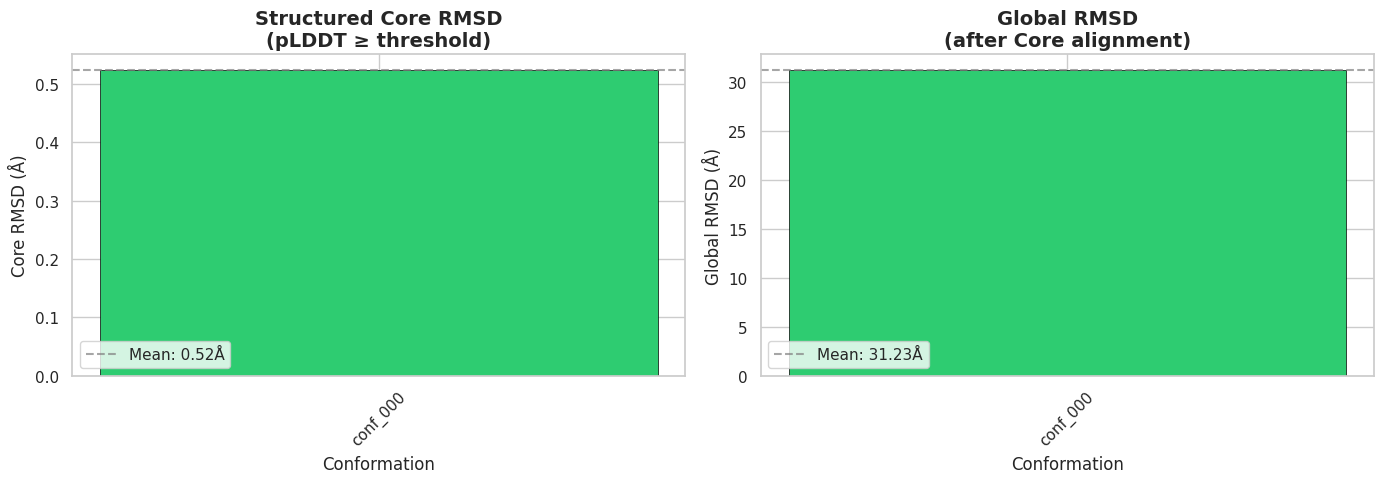

In [52]:
# Visualization: RMSD plot
if pipeline.rmsd_results:
    fig = StructureVisualizer.plot_rmsd_comparison(
        pipeline.rmsd_results,
        best_id=pipeline.best_result.sample_id
    )
    plt.savefig(OUTPUT_DIR / f"{UNIPROT_ID}_{MUTATION}_rmsd_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()

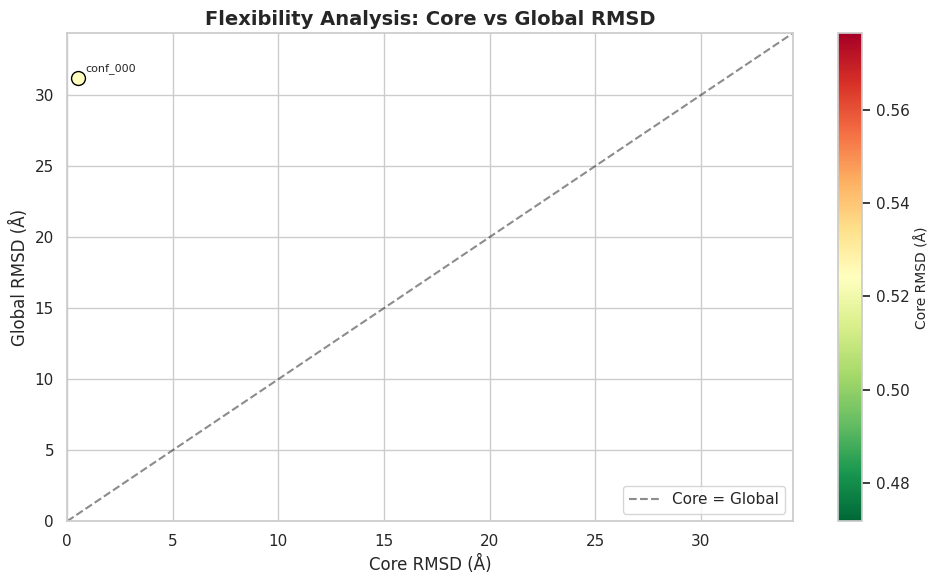

In [53]:
# Visualization: Flexibility Analysis (Core vs Global)
if pipeline.rmsd_results:
    fig = StructureVisualizer.plot_flexibility_analysis(pipeline.rmsd_results)
    plt.savefig(OUTPUT_DIR / f"{UNIPROT_ID}_{MUTATION}_flexibility_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()

In [57]:
def align_and_save_best_candidate(pipeline):
    """
    Alinha a melhor candidata à WT (usando o Core) e salva no disco.
    Necessário para a visualização correta e para o RFdiffusion.
    """
    print("\n🔄 Alinhando melhor candidata para visualização...")

    # 1. Carregar estruturas
    parser = PDBParser(QUIET=True)
    wt_struct = parser.get_structure("WT", str(pipeline.wt_structure_path))
    mutant_struct = parser.get_structure("Mutant", str(pipeline.best_result.sample_path))

    # 2. Obter átomos do Core (baseado nos índices detectados anteriormente)
    core_indices = pipeline.analyzer._core_info.residue_indices

    def get_core_atoms(structure, indices):
        atoms = []
        for model in structure:
            for chain in model:
                residues = list(chain.get_residues())
                for i in indices:
                    if i < len(residues) and 'CA' in residues[i]:
                        atoms.append(residues[i]['CA'])
                return atoms # Retorna após a primeira cadeia

    wt_core = get_core_atoms(wt_struct, core_indices)
    mutant_core = get_core_atoms(mutant_struct, core_indices)

    # 3. Calcular e aplicar matriz de rotação
    si = Superimposer()
    si.set_atoms(wt_core, mutant_core)
    si.apply(mutant_struct.get_atoms()) # Aplica a rotação em TODOS os átomos da mutante

    print(f"   RMSD do alinhamento: {si.rms:.3f} Å")

    # 4. Salvar o arquivo alinhado (sobrescrevendo ou criando novo)
    output_path = pipeline.best_result.sample_path.parent / f"{pipeline.best_result.sample_id}_aligned.pdb"

    io = PDBIO()
    io.set_structure(mutant_struct)
    io.save(str(output_path))

    # Atualiza o caminho no objeto de resultado para o visualizador usar o arquivo novo
    pipeline.best_result.sample_path = output_path
    print(f"✅ Arquivo alinhado salvo: {output_path.name}")

# --- EXECUTE ISSO ANTES DA CÉLULA DE VISUALIZAÇÃO 3D ---
if pipeline.best_result:
    align_and_save_best_candidate(pipeline)

# Interactive 3D Visualization: WT vs Best Mutant
if pipeline.best_result and pipeline.wt_structure_path:
    view = StructureVisualizer.visualize_structures_3d(
        wt_pdb_path=pipeline.wt_structure_path,
        mutant_pdb_path=pipeline.best_result.sample_path,
        mutation_position=pipeline.mutation_info.position
    )

    print("\n🔍 3D Visualization:")
    print("   • Gray (transparent): Wild Type (AlphaFold)")
    print("   • Green (solid): Best mutant conformation")
    print("   • Red (stick): Mutated residue")

    view.show()


🔄 Alinhando melhor candidata para visualização...
   RMSD do alinhamento: 0.524 Å
✅ Arquivo alinhado salvo: conf_000_aligned.pdb

🔍 3D Visualization:
   • Gray (transparent): Wild Type (AlphaFold)
   • Green (solid): Best mutant conformation
   • Red (stick): Mutated residue


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [55]:
# List generated files
print("\n📁 GENERATED FILES:")
print("=" * 50)

for directory in [STRUCTURES_DIR, BIOEMU_DIR, OUTPUT_DIR]:
    if directory.exists():
        files = list(directory.iterdir())
        if files:
            print(f"\n📂 {directory}:")
            for f in files:
                size = f.stat().st_size / 1024  # KB
                print(f"   └─ {f.name} ({size:.1f} KB)")


📁 GENERATED FILES:

📂 mutation_pipeline_results/structures:
   └─ AF-P50995-F1-model_v6.pdb (309.3 KB)

📂 mutation_pipeline_results/bioemu_results:
   └─ P50995_P36R (4.0 KB)

📂 mutation_pipeline_results/output:
   └─ P50995_P36R_best_for_rfdiffusion.pdb (192.9 KB)
   └─ P50995_P36R_flexibility_analysis.png (76.7 KB)
   └─ P50995_P36R_rmsd_comparison.png (67.5 KB)


---
## 📌 Next Steps: RFdiffusion

The exported PDB file (`*_best_for_rfdiffusion.pdb`) is ready to be used as input for **RFdiffusion** for binder design.

### Example RFdiffusion command:

```bash
python scripts/run_inference.py \
    inference.input_pdb=path/to/mutant_best_for_rfdiffusion.pdb \
    inference.output_prefix=binder_design \
    'contigmap.contigs=[A1-100/0 B1-80]' \
    inference.num_designs=10
```

### Considerations:
1. **Hotspot selection**: Identify functionally important residues near the mutation
2. **Binder size**: Adjust according to application (60-100 residues is typical)
3. **Validation**: Use AlphaFold2-Multimer or ColabFold to validate generated complexes

In [56]:
# Final cell: Version and environment information
print("\n📋 ENVIRONMENT INFORMATION:")
print("=" * 50)

import sys
print(f"Python: {sys.version}")

try:
    import Bio
    print(f"BioPython: {Bio.__version__}")
except:
    pass

try:
    import torch
    print(f"PyTorch: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
except:
    pass

print(f"\n✅ Pipeline completed successfully!")


📋 ENVIRONMENT INFORMATION:
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
BioPython: 1.86
PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4

✅ Pipeline completed successfully!
